# **News Media**

In [1]:
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# DB 연결
# !pip install pymysql
import pymysql

# 실시간 주식가격 데이터
# !pip install finance-datareader
import FinanceDataReader as fdr

# 텍스트 분석
from konlpy.tag import Okt
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# 기타
import datetime
from collections import Counter
import sys

## **Read Data**

### **① KOSELF 감성 어휘 사전**

In [2]:
# 블로그에서 가져온 기본적인 한국어 긍부정 텍스트 목록
with open('positive_words_self.txt', encoding='utf-8') as pos_blog:
    positive_blog = pos_blog.readlines()
positive_blog = [pos_blog.replace('\n', '') for pos_blog in positive_blog]
with open('negative_words_self.txt', encoding='utf-8') as neg_blog:
    negative_blog = neg_blog.readlines()
negative_blog = [neg_blog.replace('\n', '') for neg_blog in negative_blog]

# KOSELF 감성 어휘 사전
with open('KOSELF_pos.txt', encoding='utf-8') as pos:
    positive = pos.readlines()
positive = [pos.replace('\n', '') for pos in positive]
with open('KOSELF_neg.txt', encoding='utf-8') as neg:
    negative = neg.readlines()
negative = [neg.replace('\n', '') for neg in negative]

### **② 연습용 데이터**

In [3]:
# 연습용 데이터 로드 & 통합
samsung = pd.read_csv('test_samsung.csv')
hyundai = pd.read_csv('test_hyundai.csv')
lg = pd.read_csv('test_lg.csv')
sk = pd.read_csv('test_sk.csv')

In [4]:
##### 연습용 데이터 사용할 때만 필요한 과정 #####
corp_list = ['samsung', 'hyundai', 'lg', 'sk']

for i in range(len(corp_list)):
    globals()[corp_list[i]]['date'] = pd.to_datetime(globals()[corp_list[i]]['date'])

### **③ FinanceDataReader**

In [5]:
corp_list = ['samsung', 'hyundai', 'lg', 'sk']
stock_num_list = ['005930', '005380', '051910', '000660']

start_date = '20180101'
end_date = datetime.datetime.now().strftime("%Y%m%d")

for i in range(len(corp_list)):
    globals()['stock_' + corp_list[i]] = fdr.DataReader(stock_num_list[i], start=start_date, end=end_date).reset_index()

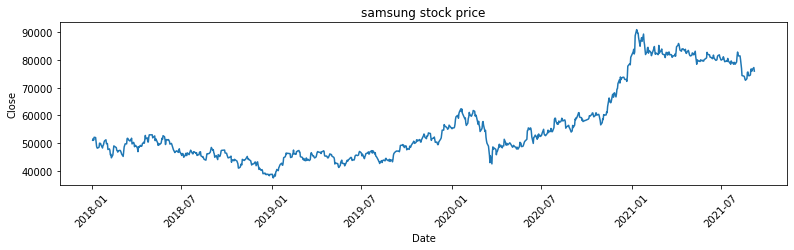

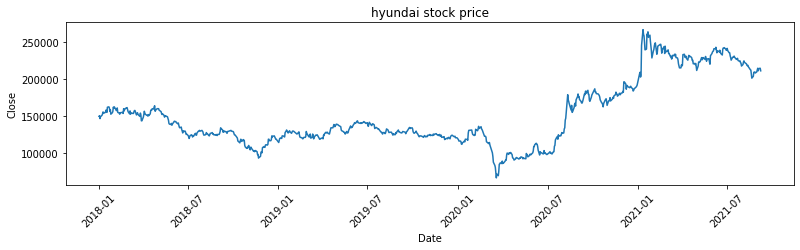

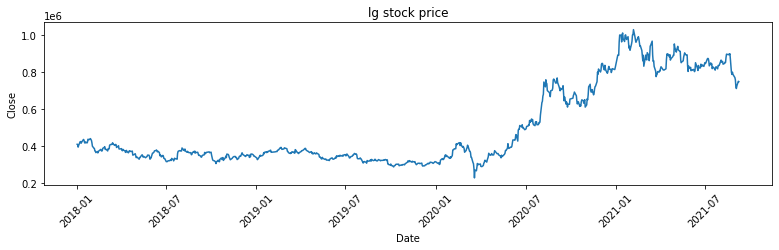

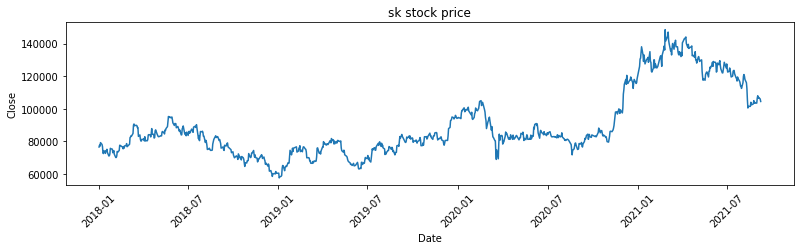

In [6]:
# 종목별 주식가격 변동
for i in range(len(corp_list)):
    plt.figure(figsize=(60, 3))
    plt.subplot(1, 4, i+1)
    sns.lineplot(data=globals()['stock_' + corp_list[i]], x='Date', y='Close')
    plt.title(corp_list[i] + ' stock price')
    plt.xticks(rotation=45)

plt.show()

## **Sentiment Anlaysis**

### **① 종목별 긍부정 Score 계산**

In [7]:
for i in range(len(corp_list)):
    globals()[corp_list[i] + '_test'] = globals()[corp_list[i]].copy()

In [8]:
for i in range(len(corp_list)):
    globals()[corp_list[i]]['score'] = 0
    tokenizer = Okt()
    
    for x in range(len(globals()[corp_list[i]]['date'])):
        score = 0
        num = tokenizer.nouns(globals()[corp_list[i]]['text'][x])
        for y in num:
            if y in positive:
                score += 1
            elif y in negative:
                score -= 1
            else:
                score = score
        
        globals()[corp_list[i]]['score'][x] = score

<ipython-input-8-53cc9633972b>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  globals()[corp_list[i]]['score'][x] = score


In [9]:
for i in range(len(corp_list)):
    globals()[corp_list[i] + '_test']['score'] = 0
    tokenizer = Okt()
    
    for x in range(len(globals()[corp_list[i] + '_test']['date'])):
        score = 0
        num = tokenizer.nouns(globals()[corp_list[i] + '_test']['text'][x])
        for y in num:
            if y in positive_blog:
                score += 1
            elif y in negative_blog:
                score -= 1
            else:
                score = score
        
        globals()[corp_list[i] + '_test']['score'][x] = score

<ipython-input-9-0a019e114b76>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  globals()[corp_list[i] + '_test']['score'][x] = score


In [10]:
for i in range(len(corp_list)):
    globals()[corp_list[i] + '_daily'] = globals()[corp_list[i]].groupby('date').mean().reset_index()

In [11]:
for i in range(len(corp_list)):
    globals()[corp_list[i] + '_daily_test'] = globals()[corp_list[i] + '_test'].groupby('date').mean().reset_index()

### **② 주식가격 데이터와 결합**

In [12]:
type(samsung_daily['date'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [13]:
type(stock_samsung['Date'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [14]:
for i in range(len(corp_list)):
    globals()['total_' + corp_list[i]] = pd.merge(globals()[corp_list[i] + '_daily'], globals()['stock_' + corp_list[i]], how='left', left_on='date', right_on='Date')
    globals()['total_' + corp_list[i]].drop('Date', axis=1, inplace=True)

In [15]:
for i in range(len(corp_list)):
    globals()['total_' + corp_list[i] + '_test'] = pd.merge(globals()[corp_list[i] + '_daily_test'], globals()['stock_' + corp_list[i]], how='left', left_on='date', right_on='Date')
    globals()['total_' + corp_list[i] + '_test'].drop('Date', axis=1, inplace=True)

In [16]:
total = pd.concat([total_samsung, total_hyundai, total_lg, total_sk], axis=0)

# 주말 및 공휴일 제외 확인
total[total['date']=='2021-08-29']

,date,st_cd,datetime,time,score,Open,High,Low,Close,Volume,Change


In [17]:
total.head()

,date,st_cd,datetime,time,score,Open,High,Low,Close,Volume,Change
0,2020-01-02,5930.0,2.020010e+09,10.407407,0.407407,55500.0,56000.0,55000.0,55200.0,12993228.0,-0.010753
1,2020-01-03,5930.0,2.020010e+09,11.432432,2.054054,56000.0,56600.0,54900.0,55500.0,15422255.0,0.005435
2,2020-01-06,5930.0,2.020010e+09,12.403509,0.368421,54900.0,55600.0,54600.0,55500.0,10278951.0,0.000000
3,2020-01-07,5930.0,2.020011e+09,13.153846,0.230769,55700.0,56400.0,55600.0,55800.0,10009778.0,0.005405
4,2020-01-08,5930.0,2.020011e+09,11.285714,0.619048,56200.0,57400.0,55900.0,56800.0,23501171.0,0.017921


In [18]:
total_test = pd.concat([total_samsung_test, total_hyundai_test, total_lg_test, total_sk_test], axis=0)

# 주말 및 공휴일 제외 확인
total_test[total_test['date']=='2021-08-29']

,date,st_cd,datetime,time,score,Open,High,Low,Close,Volume,Change


In [19]:
total_test.head()

,date,st_cd,datetime,time,score,Open,High,Low,Close,Volume,Change
0,2020-01-02,5930.0,2.020010e+09,10.407407,1.629630,55500.0,56000.0,55000.0,55200.0,12993228.0,-0.010753
1,2020-01-03,5930.0,2.020010e+09,11.432432,1.378378,56000.0,56600.0,54900.0,55500.0,15422255.0,0.005435
2,2020-01-06,5930.0,2.020010e+09,12.403509,0.912281,54900.0,55600.0,54600.0,55500.0,10278951.0,0.000000
3,2020-01-07,5930.0,2.020011e+09,13.153846,1.461538,55700.0,56400.0,55600.0,55800.0,10009778.0,0.005405
4,2020-01-08,5930.0,2.020011e+09,11.285714,-1.142857,56200.0,57400.0,55900.0,56800.0,23501171.0,0.017921


In [22]:
total.to_csv('test_total_KOSELF.csv', index=False)

In [23]:
total.to_csv('test_total_blog.csv', index=False)

### **③ 날짜별 주식가격 변동 예측 정확도**

In [20]:
(len(total[(total['Change']>0) & (total['score']>0)]) + len(total[(total['Change']<0) & (total['score']<0)])) / len(total['score'])

0.4794188861985472

In [21]:
(len(total_test[(total_test['Change']>0) & (total_test['score']>0)]) + len(total_test[(total_test['Change']<0) & (total_test['score']<0)])) / len(total_test['score'])

0.4648910411622276